# Notebook 3a - final analysis, constant lifetime assumption

## Intro

This Jupyter notebook presents part of the model behind the publication: 
> Krych, K. & Pettersen, JB. (2024). Long-term lifetime trends of large appliances since the introduction in Norwegian households. Journal of Industrial Ecology. 

Here, we perform the final analysis assuming that the lifetime scale parameter follows a constant function. We keep all parameters fixed, except for "inflows of appliances (I)". We divide the inflows of appliances into approximately decade-long segments, which we vary independently. 

## Imports and simulation setup

In [1]:
import sys, os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import least_squares
from SALib.sample import saltelli
from SALib.analyze import sobol
import time
import math

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'ODYM/odym/modules')))
import ODYM_Classes as msc # import the ODYM class file
from timeseriessegments import TimeSeriesSegments

In [2]:
TimeStart = 1940
TimeEnd = 2022
SampleSize = 2**5

problem = {}
param_values = {}
variables = {}
MyYears = list(range(TimeStart,TimeEnd+1))
variables_for_UA = ['I']

In [3]:
# all values below are relative changes in parameters (percentage changes)
u_i = 0.05
u_k = 0.1   
u_p = 0.01     
u_ppd = 0.01    
u_lambda_cab = 0.2 
u_k_cab = 0.2 
u_soce = 0.2     
u_i_cab = 0.01    

## Functions

In [ ]:
import funct # most functions are imported from funct.py

In [4]:
def lt_par_to_scale(t, lt_par):
    [C0] = lt_par
    scale = np.ones_like(t)*C0
    return scale

In [5]:
def perform_MFA(lt_par, dict_values):
    t = dict_values['t']
    scale = lt_par_to_scale(t, lt_par)
    # create a 2D array with shape parameters
    lt_shape = np.full((len(t),len(t)), dict_values['k'], dtype=float)
    lt_shape = np.tril(lt_shape, 0)
    # create a 2D array with scale parameters
    lt_scale = np.repeat(np.reshape(scale,(len(scale),1)), repeats=len(scale), axis=1)
    lt_scale = np.tril(lt_scale, 0)
    lt = {'Type': 'Weibull', 'Shape': lt_shape,'Scale': lt_scale}
    # __find_unique_lt__
    params = {k:v for k,v in lt.items() if k!= 'Type'}
    sets = np.concatenate([[p] for p in params.values()], axis=0) # stacks all the p parameters
    sets = sets.reshape(len(params),-1) # reshapes from 3D form (p,t,t) into 2D form (p,t*t)
    unique, inverse = np.unique(sets, return_inverse=True, axis=1)
    inverse = inverse.reshape(len(t),len(t)) # reshapes from 1D form (t*t) into 2D form (t,t)
    length = np.shape(unique)[1]
    unique = {k:unique[p,:] for p,k in enumerate(params.keys())}
    # __compute_hz__
    hz_unique = np.zeros((len(t),length))
    for i in range(length): # for each unique parameter set
        if unique['Scale'][i] != 0:
            sf = scipy.stats.weibull_min.sf(np.arange(len(t)), c=unique['Shape'][i], loc = 0, scale=unique['Scale'][i])
            hz_unique[0,i] = 1-sf[0]
            for m in range(len(t)-1): # for each age m
                if sf[m] != 0:
                    hz_unique[m+1,i] = (sf[m] - sf[m+1]) / sf[m]
                else:
                    hz_unique[m+1,i] = 1
    hz = np.zeros((len(t), len(t)))
    for cohort in range(len(t)): # for each cohort c
        for time in range(cohort,len(t)): # for each year t 
            hz[time,cohort] = hz_unique[time-cohort,inverse[time,cohort]]
    # compute_inflow_driven_model
    i = dict_values['I']
    s_c = np.zeros((len(t), len(t))) # stock composition per year
    o_c = np.zeros((len(t), len(t))) # outflow compositionO
    for time in range(len(t)): # for each year t
        if time>0: # the initial stock is assumed to be 0
            o_c[time,:time] = s_c[time-1,:time] * hz[time,:time] 
            # subtract outflows of cohorts <m from the previous stock 
            s_c[time,:time] = s_c[time-1,:time] - o_c[time,:time]
        # Add new cohort to stock
        s_c[time,time] = i[time]
        o_c[time,time] = s_c[time,time] * hz[time,time]
    # popd calculation
    popd = s_c.sum(axis=1)/dict_values['D']
    return popd, i, o_c, s_c, hz

In [6]:
def save_MFA_results(Dyn_MFA_System, dict_values, d, r, lt_fit):
    popd, i, o_c, s_c, hz = perform_MFA(lt_fit, dict_values)
    Dyn_MFA_System.FlowDict['F_01'].Values[:,d,r,0] = i
    Dyn_MFA_System.FlowDict['F_10c'].Values[:,:,d,r,0] = o_c
    Dyn_MFA_System.ExtraDict['F_10'].Values[:,d,r] = np.sum(o_c, axis=1)
    Dyn_MFA_System.StockDict['S_1c'].Values[:,:,d,r,0] = s_c
    Dyn_MFA_System.ExtraDict['S_1'].Values[:,d,r] = np.sum(s_c, axis=1)
    Dyn_MFA_System.ExtraDict['POpD'].Values[:,d,r]= popd
    Dyn_MFA_System.ExtraDict['hz'].Values[:,:,d,r]= hz
    Dyn_MFA_System.ExtraDict['LT-l'].Values[:,d,r] = lt_fit[0]
    return Dyn_MFA_System

In [7]:
def errfunc_var(lt_par, xdata, ydata, dict_values_r):
    popd, i, o_c, s_c, hz = perform_MFA(lt_par, dict_values_r)
    return popd[xdata-TimeStart]-ydata

## Model definition

In [8]:
ModelClassification_app  = {} # Create dictionary of model classifications

ModelClassification_app['Time'] = msc.Classification(Name = 'Time', Dimension = 'Time', ID = 1, 
                                                 Items = MyYears)
ModelClassification_app['Cohort'] = msc.Classification(Name = 'Cohort', Dimension = 'Time', ID = 2, 
                                                 Items = MyYears)
ModelClassification_app['Element'] = msc.Classification(Name= 'Elements', Dimension = 'Element', ID = 3, 
                                                    Items = ['C'])
ModelClassification_app['Durable'] = msc.Classification(Name = 'Durable', Dimension = 'Durable', ID = 4, 
                                                    Items = ['fridge & fridge freezer' ,'freezer','washing machine', 'tumble dryer', 'dishwasher', 'oven'])
ModelClassification_app['Run'] = msc.Classification(Name = 'Model run', Dimension = 'Run', ID = 5, 
                                                    Items = [])
aspects = ['Time','Element','Cohort', 'Durable', 'Run']
letters = ['t','e', 'c','d', 'r']
IndexTable = pd.DataFrame({'Aspect'        : aspects, # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect ' + asp for asp in aspects],
                           'Dimension'     : [asp if asp != 'Cohort' else 'Time' for asp in aspects], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification_app[Aspect] for Aspect in aspects],
                           'IndexLetter'   : letters}) # Unique one letter (upper or lower case) indices to be used later for calculations.
IndexTable.set_index('Aspect', inplace = True) 
IndexTable['IndexSize'] = \
    pd.Series([len(IndexTable.Classification[i].Items) for i in range(0,len(IndexTable.IndexLetter))], index=IndexTable.index)

In [9]:
Dyn_MFA_System = msc.MFAsystem(Name = 'ApplianceSystem_constantLT', 
                      Geogr_Scope = 'Norway', 
                      Unit = '1', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = {}, 
                      Time_Start = int(min(ModelClassification_app['Time'].Items)), 
                      Time_End = int(max(ModelClassification_app['Time'].Items)), 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

In [10]:
Dyn_MFA_System.ProcessList = [] # Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Environment', ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Process 1'  , ID   = 1))

In [11]:
Dyn_MFA_System.ParameterDict = {
    'I': msc.Parameter(Name = 'Inflow', Indices = 'td', Values=None, Unit = '1/yr'),
    'k': msc.Parameter(Name = 'Durable lifetime (shape)', Indices = 'd', Values=None, Unit = '1'),
    'D': msc.Parameter(Name = 'Number of dwellings (primary and secondary)', Indices = 't', Values=None, Unit = '1')}

excel = os.path.abspath(os.path.join(os.getcwd(), 'data.xlsx'))
for k in Dyn_MFA_System.ParameterDict.keys():
    indices = Dyn_MFA_System.ParameterDict[k].Indices
    Dyn_MFA_System.ParameterDict[k].Values = funct.read_parameter_excel(IndexTable, indices, excel, sheet_name=k)

In [12]:
i_seg = {}
for d,durable in enumerate(ModelClassification_app['Durable'].Items):
    y = Dyn_MFA_System.ParameterDict['I'].Values[:,d]
    if durable in ['dishwasher', 'tumble dryer', 'freezer']:
        segs = [1970,1980,1990,2000,2010]
    else:
        segs = [1960,1970,1980,1990,2000,2010]
    i_seg[durable] =TimeSeriesSegments(x=list(MyYears),y=list(y), seg_delim=segs, y_name='I')
    i_seg[durable].add_uncertainties('norm',0,u_i)
Dyn_MFA_System.ParameterDict['I'].MetaData = i_seg

In [13]:
no_of_runs = {}
for durable in ModelClassification_app['Durable'].Items:
    variables[durable] = {}
    if variables_for_UA == ['I']:
        variables[durable] = {k: i_seg[durable].uncert[k] for k in ['names', 'bounds', 'dists']}
    else:
        variables_common = {'names': [], 'bounds': [], 'dists': []}
        for var in variables_for_UA:
            if var != 'I':
                uncert = globals()['u_'+var.lower().replace('-','_')]
                variables_common['names'].append(var)
                variables_common['bounds'].append([0,uncert])
                variables_common['dists'].append('norm')
        for k,v in variables_common.items():
            variables[durable][k] = v + i_seg[durable].uncert[k] #  + other_vars[k]
    

    problem[durable] = {
            'num_vars': len(variables[durable]['names']),
            'names': variables[durable]['names'], 
            'bounds': variables[durable]['bounds'], 
            'dists': variables[durable]['dists']
            }
    # for normal 'norm' distribution, bounds indicate mean and st.dev

    # sample
    param_values[durable] = saltelli.sample(problem[durable], SampleSize)
    no_of_runs[durable] = np.shape(param_values[durable])[0]

In [14]:
max_no_of_runs = max([no_of_runs[d] for d in  ModelClassification_app['Durable'].Items])
ModelClassification_app['Run'].Items = list(range(max_no_of_runs))
IndexTable.Classification['Run'].Items = list(range(max_no_of_runs))
IndexTable.IndexSize.loc['Run'] = max_no_of_runs

C:\Users\kamilami\AppData\Local\Temp/ipykernel_7380/2007174321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IndexTable.IndexSize.loc['Run'] = max_no_of_runs


In [15]:
# Define the four flows a,b,c,d of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_01'] = msc.Flow(Name = 'Input', P_Start = 0, P_End = 1, Indices = 't,d,r,e', Values=None)
Dyn_MFA_System.FlowDict['F_10c'] = msc.Flow(Name = 'Output', P_Start = 1, P_End = 0, Indices = 't,c,d,r,e', Values=None)
Dyn_MFA_System.StockDict['S_1c'] = msc.Stock(Name='In-use stock', P_Res=1, Type=0, Indices='t,c,d,r,e', Values=None)
Dyn_MFA_System.StockDict['dS_1'] = msc.Stock(Name='In-use stock change', P_Res=1, Type=1, Indices='t,d,r,e',Values=None)

In [16]:
Dyn_MFA_System.ExtraDict = {}
Dyn_MFA_System.ExtraDict['S_1'] = msc.Parameter(Name = 'In-use stock total', Indices = 'tdr', Values=None)
Dyn_MFA_System.ExtraDict['F_10'] = msc.Parameter(Name = 'Outflows total', Indices = 'tdr', Values=None)
Dyn_MFA_System.ExtraDict['POpD'] = msc.Parameter(Name = 'Product ownership per dwelling', Indices = 'tdr', Values=None) # POpD could have indices 'tar' but 'tdr' makes the calculations easier
Dyn_MFA_System.ExtraDict['hz'] = msc.Parameter(Name = 'Hazard matrix', Indices = 'tcdr', Values=None)
Dyn_MFA_System.ExtraDict['LT-l'] = msc.Parameter(Name = 'Durable lifetime (scale)', Indices = 'tdr', Values=None)

In [17]:
for key in Dyn_MFA_System.ExtraDict.keys():
    Dyn_MFA_System.ExtraDict[key].Values = np.zeros(tuple([len(IndexTable.set_index('IndexLetter').loc[x]['Classification'].Items) for x in Dyn_MFA_System.ExtraDict[key].Indices]))
Dyn_MFA_System.Initialize_FlowValues()
Dyn_MFA_System.Initialize_StockValues() 
Dyn_MFA_System.Consistency_Check()

(True, True, True)

## Analysis

In [18]:
df_popd = funct.read_data_excel(IndexTable, 'td',excel, sheet_name='POpD_data')
start_regression = time.time()
for d,durable in enumerate(ModelClassification_app['Durable'].Items):
    start_regression_d = time.time()
    print(f"Fitting lifetime for {durable}...")
    dict_values = funct.reduce_dimensions(IndexTable, durable, Dyn_MFA_System.ParameterDict)
    df_d = df_popd[df_popd['durable'] == durable]
    xdata = df_d['time'].values
    ydata = df_d['value'].values
    for r in range(no_of_runs[durable]):
        dict_values_r = funct.multiply_by_uncertainty(durable, problem[durable], param_values[durable][r,:], dict_values,Dyn_MFA_System.ParameterDict)
        dict_values_r['t'] = MyYears
        lt_par0 = [20] 
        bounds = ([0],[40])
        lt_fit_result = least_squares(errfunc_var, lt_par0, bounds=bounds, args=(xdata, ydata, dict_values_r))
        
        Dyn_MFA_System = save_MFA_results(Dyn_MFA_System, dict_values_r, d, r, lt_fit_result.x)
        if r % 100 == 0 and r != 0:
            print(f'iteration {r} in {no_of_runs[durable]}')
        
    end_regression_d = time.time()
    print(f'Time elapsed for {durable}: {math.trunc((end_regression_d-start_regression_d)/60)} min {round((end_regression_d-start_regression_d) % 60)} s')
end_regression = time.time()
print(f'Time elapsed total: {math.trunc((end_regression-start_regression)/60)} min {round((end_regression-start_regression) % 60)} s')

Fitting lifetime for fridge & fridge freezer...
iteration 100 in 512
iteration 200 in 512
iteration 300 in 512
iteration 400 in 512
iteration 500 in 512
Time elapsed for fridge & fridge freezer: 1 min 19 s
Fitting lifetime for freezer...
iteration 100 in 448
iteration 200 in 448
iteration 300 in 448
iteration 400 in 448
Time elapsed for freezer: 1 min 6 s
Fitting lifetime for washing machine...
iteration 100 in 512
iteration 200 in 512
iteration 300 in 512
iteration 400 in 512
iteration 500 in 512
Time elapsed for washing machine: 1 min 7 s
Fitting lifetime for tumble dryer...
iteration 100 in 448
iteration 200 in 448
iteration 300 in 448
iteration 400 in 448
Time elapsed for tumble dryer: 1 min 2 s
Fitting lifetime for dishwasher...
iteration 100 in 448
iteration 200 in 448
iteration 300 in 448
iteration 400 in 448
Time elapsed for dishwasher: 0 min 49 s
Fitting lifetime for oven...
iteration 100 in 512
iteration 200 in 512
iteration 300 in 512
iteration 400 in 512
iteration 500 in 51

In [19]:
mu = np.zeros([len(ModelClassification_app['Time'].Items), len(ModelClassification_app['Durable'].Items)+1, len(ModelClassification_app['Run'].Items)])
for d,durable in enumerate(ModelClassification_app['Durable'].Items):
    dict_values = funct.reduce_dimensions(IndexTable, durable, Dyn_MFA_System.ParameterDict)
    for r in range(no_of_runs[durable]):
        dict_values_r = funct.multiply_by_uncertainty(durable, problem[durable], param_values[durable][r,:], dict_values,Dyn_MFA_System.ParameterDict)
        scale = Dyn_MFA_System.ExtraDict['LT-l'].Values[:,d,r]
        mu[:,d,r] = funct.mean_from_scale_parameters(scale, dict_values_r)
Dyn_MFA_System.ExtraDict['mu'] = msc.Parameter(Name = 'Durable lifetime (mean)', Indices = 'tdr', Values=mu)

In [20]:
age_o_i = np.empty((len(MyYears), len(ModelClassification_app['Durable'].Items), no_of_runs[durable]))
age_o = np.empty((len(MyYears), len(ModelClassification_app['Durable'].Items), no_of_runs[durable]))
for d, durable in enumerate(ModelClassification_app['Durable'].Items):
    for r in range(no_of_runs[durable]):
        o_c = Dyn_MFA_System.FlowDict['F_10c'].Values[:,:,d,r,0]
        age_o_i[:,d,r] = funct.calculate_age(o_c,isstock=False,inflows=Dyn_MFA_System.FlowDict['F_01'].Values[:,d,r,0])
        age_o[:,d,r] = funct.calculate_age(o_c,isstock=False)
Dyn_MFA_System.ExtraDict['age_o_i'] = msc.Parameter(Name = 'Mean age of outflows, scaled by inflows', Indices = 'tdr', Values=age_o_i)
Dyn_MFA_System.ExtraDict['age_o'] = msc.Parameter(Name = 'Mean age of outflows', Indices = 'tdr', Values=age_o)

In [21]:
with open("3a_analysis_constant.dat", "wb") as f:
    pickle.dump([Dyn_MFA_System, problem, param_values, no_of_runs], f)

## Plotting

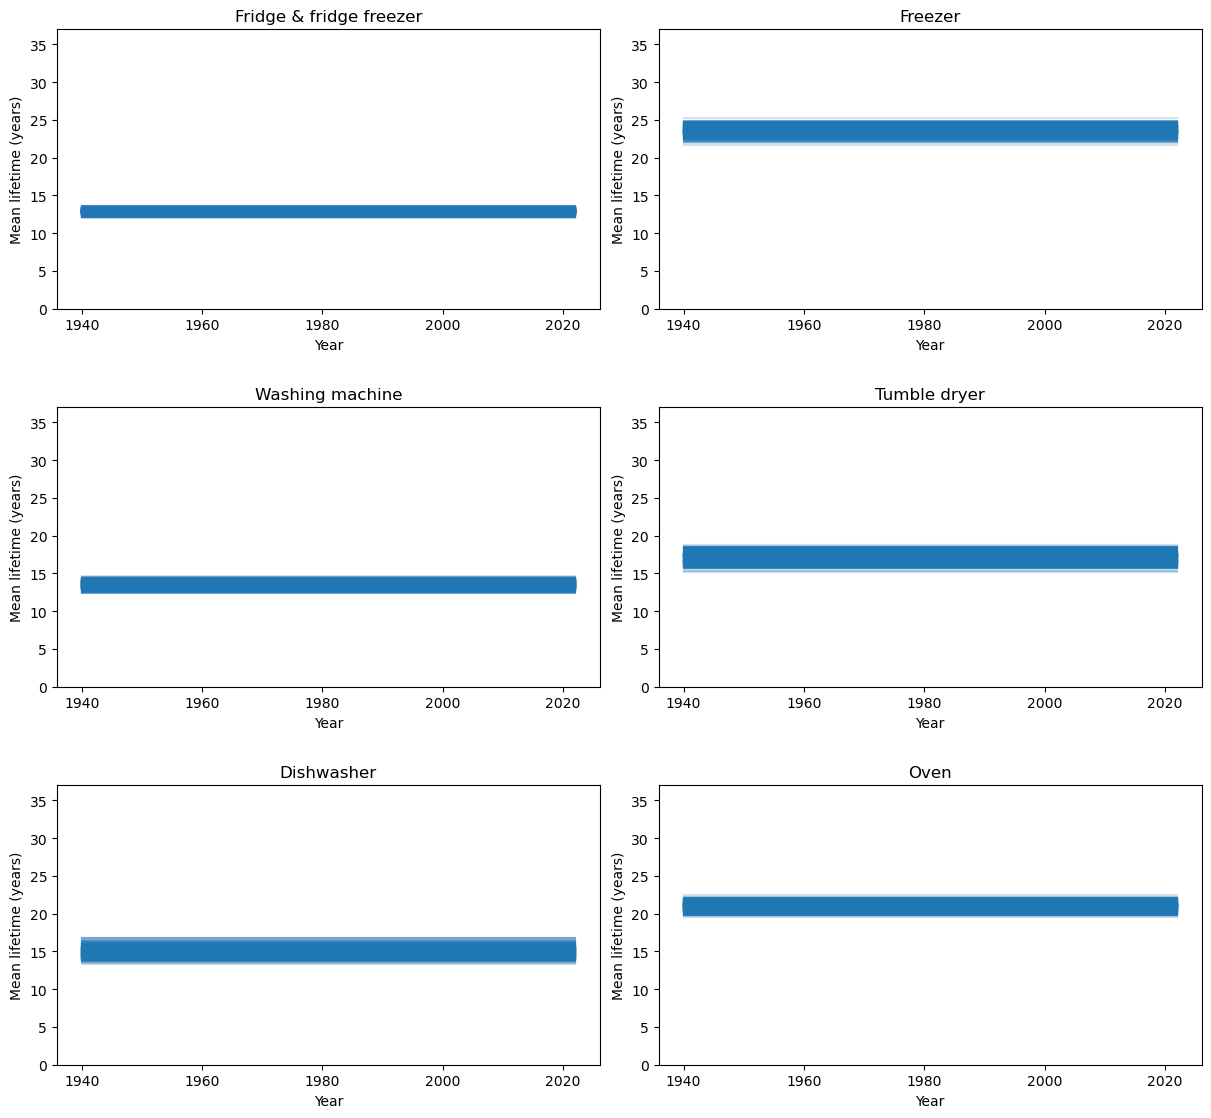

In [30]:
x = IndexTable.Classification['Time'].Items
columns = 2
rows = 4
fig = plt.figure(figsize=(6*columns, 3.5*rows), constrained_layout=True)
# fig.set_dpi(dpi) #min 600 for publication
gs = fig.add_gridspec(rows, columns,hspace=0.1)
row = 0
col = 0
for d,durable in enumerate(ModelClassification_app['Durable'].Items):
    ax = fig.add_subplot(gs[row, col])
    for r in range(no_of_runs[durable]):
        ax.plot(MyYears, mu[:,d,r], color='C0', alpha=0.2)
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean lifetime (years)')
    ax.set_title(durable.capitalize())
    ax.set_ylim(0, 37)
    if col == columns-1:
        col = 0
        row+= 1
    else:
        col += 1

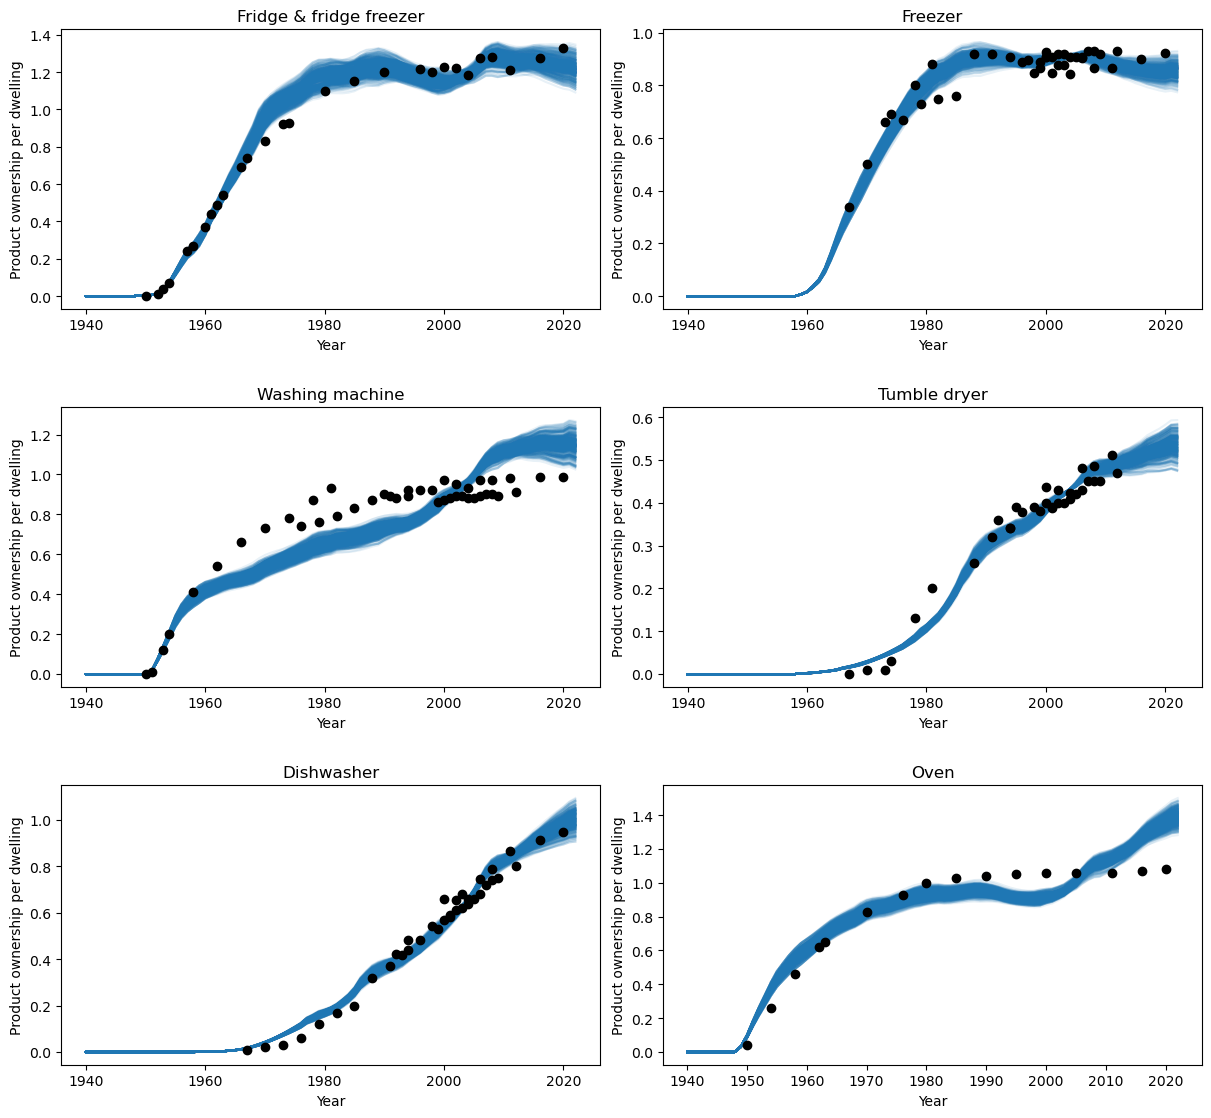

In [23]:
x = IndexTable.Classification['Time'].Items
columns = 2
rows = 4
fig = plt.figure(figsize=(6*columns, 3.5*rows), constrained_layout=True)
# fig.set_dpi(dpi) #min 600 for publication
gs = fig.add_gridspec(rows, columns,hspace=0.1)
row = 0
col = 0
df_popd = funct.read_data_excel(IndexTable, 'td',excel, sheet_name='POpD_data')
for d,durable in enumerate(ModelClassification_app['Durable'].Items):
    df_d = df_popd[df_popd['durable'] == durable]
    ax = fig.add_subplot(gs[row, col])
    for r in range(no_of_runs[durable]):
        popd_model = Dyn_MFA_System.ExtraDict['POpD'].Values[:,d,r]
        ax.plot(MyYears, popd_model, color='C0', alpha=0.1, zorder=r)
    ax.set_xlabel('Year')
    ax.set_ylabel('Product ownership per dwelling')
    ax.set_title(durable.capitalize())
    ax.scatter(df_d['time'].values,df_d['value'].values, color='black', zorder=r+1)
    if col == columns-1:
        col = 0
        row+= 1
    else:
        col += 1
plt.xlim(1940-4,2022+4)
plt.show()